In [58]:
import numpy as np
from matplotlib import pyplot as plt
import time
import pylab as pl
from IPython import display
from parameters import *
from micro import *
from aero_init import *
from parcel import *
from condensation import *
from collision import *
from analysis import *
from print_plot import *
from animation import *
from user_parameters import *

import itertools
import matplotlib

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Intialization
## Input parameter

In [64]:
# model steering parameters
dt_widget, nt_widget, Condensation_widget, Collision_widget, n_particles_widget, n_particles_slider, collision_start_t_widget, max_z_widget = model_steering_input()
# section for widgets for parcel info
T_widget, P_widget, RH_widget, w_widget = parcel_info_input()

'Model steering parameters'

BoundedFloatText(value=0.5, description='dt [s]:', max=5.0, min=0.0001)

IntText(value=3600, description='nt:')

Checkbox(value=True, description='Condensation:')

Checkbox(value=False, description='Collision:')

BoundedIntText(value=500, description='n_particles:', max=1000, min=500)

IntSlider(value=500, description=' ', max=1000, min=500)

BoundedIntText(value=0, description='collision start time [s]:', max=10000)

BoundedFloatText(value=1400.0, description='z_max [m]:', max=1400.0, step=0.1)

'Parcel initial parameters: '

BoundedFloatText(value=293.2, description='T [K]:', max=320.0, min=200.0, step=0.1)

BoundedFloatText(value=101300.0, description='P [Pa]:', max=105000.0, min=95000.0, step=1.0)

BoundedFloatText(value=0.88, description='RH [-]:', max=0.99, min=0.01, step=0.01)

BoundedFloatText(value=0.5, description='w [m/s]:', max=10.0, step=0.1)

In [49]:
# user can choice the ascending mode
ascending_mode_widget = widgets.ToggleButtons(options=['linear', 'sine', 'in_cloud_oscillation'], value='linear', description='ascending', layout={'width': 'max-content'}, disabled=False)
display('ascending mode: ', ascending_mode_widget)
# maybe include more advanced ascending modes later

'ascending mode: '

ToggleButtons(description='ascending', layout=Layout(width='max-content'), options=('linear', 'sine', 'in_clou…

In [50]:
# widgets for aerosol initialisation
mode_aero_init_widget = widgets.ToggleButtons(options=['weighting_factor', 'random'], value='weighting_factor', description='mode of aerosol init.:', layout={'width': 'max-content'}, disabled=False)

# Display widgets
display('Aerosol initialisation: ', mode_aero_init_widget)

'Aerosol initialisation: '

ToggleButtons(description='mode of aerosol init.:', layout=Layout(width='max-content'), options=('weighting_fa…

In [51]:
# N, mu, sigma for each mode
# widgets in GridspecLayout
# see: https://ipywidgets.readthedocs.io/en/latest/examples/Layout%20Templates.html#style-attributes
print('Please insert the parameters for each mode (=row). If you only want e.g. 2 modes, leave the last two rows empty')
print('Click on the heading buttons to plot the distributions of the respective modes.')
print('N_aero: number of aerosols per cubic centimeter, mu: mean droplet radius, sigma: std of mu')

gridwidget = widgets.GridspecLayout(4, 4)

# work in progress, values not yet adapted
# col 0 for mode 1
gridwidget[0, 0]= widgets.Button(description='Mode #1 (plot)', disabled=False, button_style='info', tooltip='Heading')
# idea: print distribution on clicking
# see: https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html#button
gridwidget[1, 0] = widgets.BoundedFloatText(description='N_aero[cm⁻3]', min = 0.0, max = 5000.0, step = 0.1, value=1000.0)
# internally multiply this by 1E6
gridwidget[2, 0] = widgets.BoundedFloatText(description='mu [µm]', min = 0.0, max = 5.0, step = 0.001, value=0.008)
# internally multiply this by 1E-6 and take the log
gridwidget[3, 0] = widgets.BoundedFloatText(description='sigma [-]', min = 0.0, max = 3.0, step = 0.1, value=1.6)
# internally take the log

# col 1 for mode 2
gridwidget[0, 1]= widgets.Button(description='Mode #2 (plot)', disabled=False, button_style='info', tooltip='Heading')

gridwidget[1, 1] = widgets.BoundedFloatText(description='N_aero[cm⁻3]', min = 0.0, max = 5000.0, step = 0.1, value=800.0)
# internally multiply this by 1E6
gridwidget[2, 1] = widgets.BoundedFloatText(description='mu [µm]', min = 0.0, max = 5.0, step = 0.001, value=0.034)
# internally multiply this by 1E-6 and take the log
gridwidget[3, 1] = widgets.BoundedFloatText(description='sigma [-]', min = 0.0, max = 3.0, step = 0.1, value=2.1)
# internally take the log

# col 2 for mode 3
gridwidget[0, 2]= widgets.Button(description='Mode #3 (plot)', disabled=False, button_style='info', tooltip='Heading')

gridwidget[1, 2] = widgets.BoundedFloatText(description='N_aero[cm⁻3]', min = 0.0, max = 5000.0, step = 0.01, value=0.72)
# internally multiply this by 1E6
gridwidget[2, 2] = widgets.BoundedFloatText(description='mu [µm]', min = 0.0, max = 5.0, step = 0.1, value=0.46)
# internally multiply this by 1E-6 and take the log
gridwidget[3, 2] = widgets.BoundedFloatText(description='sigma [-]', min = 0.0, max = 3.0, step = 0.1, value=2.2)
# internally take the log


# col 3 for mode 4
gridwidget[0, 3]= widgets.Button(description='Mode #4 (plot)', disabled=False, button_style='info', tooltip='Heading')

gridwidget[1, 3] = widgets.BoundedFloatText(description='N_aero[cm⁻3]', min = 0.0, max = 5000.0, step = 0.1, value=0)
# internally multiply this by 1E6
gridwidget[2, 3] = widgets.BoundedFloatText(description='mu [µm]', min = 0.0, max = 5.0, step = 0.1, value=0)
# internally multiply this by 1E-6 and take the log
gridwidget[3, 3] = widgets.BoundedFloatText(description='sigma [-]', min = 0.0, max = 3.0, step = 0.1, value=0)
# internally take the log


# additional button in the end for the cumulative distr.
plotbutton_widget = widgets.Button(description='Plot cumulative distr.', disabled=False, button_style='info', tooltip='Plot cumulative distribution of all modes')

display(gridwidget, plotbutton_widget)

Please insert the parameters for each mode (=row). If you only want e.g. 2 modes, leave the last two rows empty
Click on the heading buttons to plot the distributions of the respective modes.
N_aero: number of aerosols per cubic centimeter, mu: mean droplet radius, sigma: std of mu


GridspecLayout(children=(Button(button_style='info', description='Mode #1 (plot)', layout=Layout(grid_area='wi…

Button(button_style='info', description='Plot cumulative distr.', style=ButtonStyle(), tooltip='Plot cumulativ…

In [52]:
# model steering parameters as read in above
dt = dt_widget.value #0.5
nt = nt_widget.value #100

do_condensation = Condensation_widget.value  #True
do_collision    = Collision_widget.value  #False

collision_start_time = collision_start_t_widget.value
n_particles = n_particles_widget.value

#parcel info. 
T_parcel   = T_widget.value
P_parcel   = P_widget.value
RH_parcel  = RH_widget.value
w_parcel   = w_widget.value
z_parcel   = 0.0 #m

# RH to q conversion
q_parcel    = RH_parcel * esatw( T_parcel ) / ( P_parcel - RH_parcel * esatw( T_parcel ) ) * r_a / rv

# new: max_z now depends on collision_start_time and w_parcel
# => strange results if collision_start_time is quite small
# changed back to manual max_z initialization
# max_z = collision_start_time * w_parcel 

max_z = max_z_widget.value

#aerosol initialization
mode_aero_init = mode_aero_init_widget.value  # "weighting_factor", 'random'

# read in the variables given above taking into account unit factors
N_aero     = [gridwidget[1, 0].value*1.0E6, gridwidget[1, 1].value*1.0E6, gridwidget[1, 2].value*1.0E6, gridwidget[1, 3].value*1.0E6]
mu_aero    = [gridwidget[2, 0].value*1.0E-6, gridwidget[2, 1].value*1.0E-6, gridwidget[2, 2].value*1.0E-6, gridwidget[2, 3].value*1.0E-6]
sigma_aero = [gridwidget[3, 0].value, gridwidget[3, 1].value, gridwidget[3, 2].value, gridwidget[3, 3].value]

# truncate the array before taking the log if one of the N_aero_i is 0, which means that this will no longer be used
N_aero_array = np.array(N_aero) # first: convert into np.array
zeroindices  = np.where(N_aero_array==0) # get the number of ther mode which is empty
zeroindices  = zeroindices[0]       # some conversion for better usage

# conversion of the other indices
mu_aero_array = np.array(mu_aero)
sigma_aero_array = np.array(sigma_aero)

# now delete the respective item in each array (N, mu, sigma)
if len(zeroindices) > 0:
    # delete
    N_aero_array     = np.delete(N_aero_array, zeroindices)
    mu_aero_array    = np.delete(mu_aero_array, zeroindices)
    sigma_aero_array = np.delete(sigma_aero_array, zeroindices)

# now perform the log of the mu and the sigma arrays
mu_aero_array = np.log(mu_aero_array)
sigma_aero_array = np.log(sigma_aero_array)

# renaming
N_aero = N_aero_array
mu_aero = mu_aero_array
sigma_aero = sigma_aero_array
    
# if (any of the ) N_aero == 0 --> error, it should not start

# Time step routine

In [53]:
# setting of display mode while running: either output of variables in text form (fast, recommended) = 'text'
# or: continuously updated plot using plotly (slow, time & memory consuming) = 'graphics'
mode_displaytype_widget = widgets.ToggleButtons(options=['text_fast', 'graphics'], value='text_fast', description='display mode:', layout={'width': 'max-content'}, disabled=False)
display(mode_displaytype_widget)

ToggleButtons(description='display mode:', layout=Layout(width='max-content'), options=('text_fast', 'graphics…

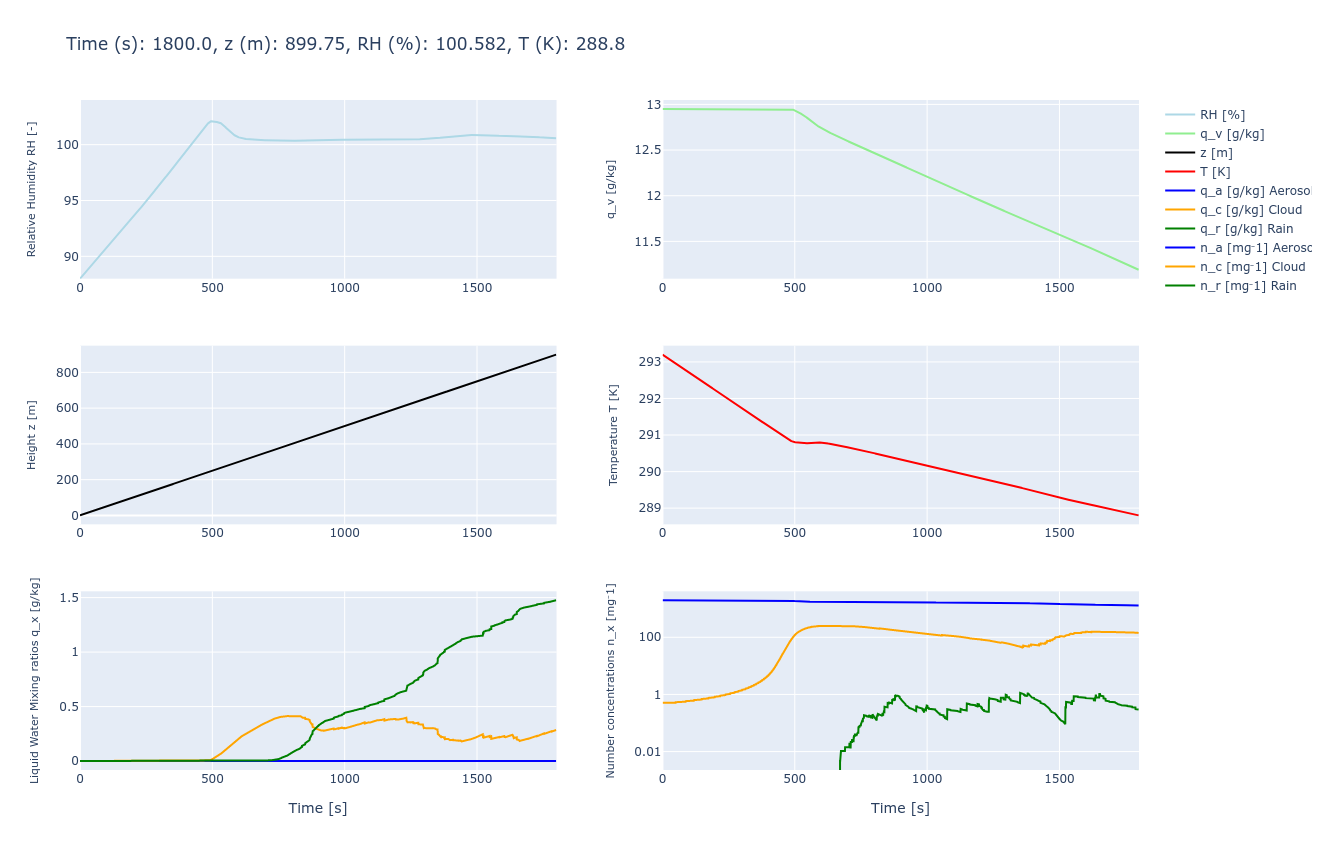

In [54]:
dz=0
rho_parcel, V_parcel, air_mass_parcel =  parcel_rho(P_parcel, T_parcel)
#Aerosol init
T_parcel, q_parcel, particles_list = aero_init(mode_aero_init, n_particles, P_parcel, T_parcel,q_parcel, N_aero, mu_aero,sigma_aero,rho_aero,molecular_weight_aero)
#parcel routine
#initalize spectrum output
spectra_arr = np.zeros((nt+1,len(rm_spec)))
# init of array for time series output
qa_ts,qc_ts,qr_ts = np.zeros(nt+1),np.zeros(nt+1),np.zeros(nt+1)
na_ts,nc_ts,nr_ts = np.zeros(nt+1),np.zeros(nt+1),np.zeros(nt+1)

spectra_arr[0],qa_ts[0], qc_ts[0],qr_ts[0], na_ts[0], nc_ts[0], nr_ts[0] = qc_qr_analysis(particles_list,air_mass_parcel,rm_spec, n_bins)

# init of array for T_parcel, RH_parcel, q_parcel and z_parcel values for each timestep
T_parcel_array  = np.zeros(nt+1)
RH_parcel_array = np.zeros(nt+1)
q_parcel_array  = np.zeros(nt+1)
z_parcel_array  = np.zeros(nt+1)


# inserting the init. values to the 0th position of the arrays
T_parcel_array[0]  = T_parcel
RH_parcel_array[0] = (q_parcel * P_parcel / (q_parcel + r_a / rv)) / esatw( T_parcel ) 
q_parcel_array[0]  = q_parcel
z_parcel_array[0]  = z_parcel

ascending_mode=ascending_mode_widget.value
time_half_wave_parcel = 600.0

# read in display mode
display_mode = mode_displaytype_widget.value

if display_mode == 'graphics':
    # initialization of animation
    figure_item = animation_init(dt, nt,rm_spec, qa_ts, qc_ts, qr_ts, na_ts, nc_ts, nr_ts, T_parcel_array, RH_parcel_array, q_parcel_array, z_parcel_array)


for t in range(nt):
    time = (t+1)*dt
    #Parcel ascending
    #if z_parcel < max_z: 
    z_parcel, T_parcel, rho_parcel, V_parcel, air_mass_parcel = ascend_parcel(z_parcel, T_parcel,P_parcel, w_parcel, dt, time, time_half_wave_parcel, ascending_mode, max_z)
    
    #Condensational Growth
    dq_liq = 0.0
    if do_condensation:
        particles_list, T_parcel, q_parcel = drop_condensation(particles_list, T_parcel, q_parcel, P_parcel, dt, air_mass_parcel, rho_aero, molecular_weight_aero)

    #Collisional Growth
    if do_collision and time > collision_start_time:
        particles_list = collection(dt, particles_list,rho_parcel, rho_liq, P_parcel, T_parcel)
    #Analysis
    spectra_arr[t+1],qa_ts[t+1], qc_ts[t+1],qr_ts[t+1], na_ts[t+1], nc_ts[t+1], nr_ts[t+1] = qc_qr_analysis(particles_list,air_mass_parcel,rm_spec, n_bins)
    RH_parcel = (q_parcel * P_parcel / (q_parcel + r_a / rv)) / esatw( T_parcel ) 
    
    # saving of T_parcel, RH_parcel, q_parcel, z_parcel for every timestep (needed for plots)
    T_parcel_array[t+1]  = T_parcel
    RH_parcel_array[t+1] = RH_parcel
    q_parcel_array[t+1]  = q_parcel
    z_parcel_array[t+1]  = z_parcel
    
    time_array = np.arange(nt+1)*dt

    if display_mode == 'text_fast':
        #Visulaization at every second
        if (time%1) ==0:
            print_output(t,dt, z_parcel, T_parcel, q_parcel, RH_parcel, qc_ts[t+1], qr_ts[t+1], na_ts[t+1], nc_ts[t+1], nr_ts[t+1])
    elif display_mode == 'graphics':
        # function to draw and update the plotly figure, every 5 seconds (idea for time saving)
        if (time%5) == 0:
            animation_call(figure_item, time_array, t, dt, nt,rm_spec, qa_ts, qc_ts, qr_ts, na_ts, nc_ts, nr_ts, T_parcel_array, RH_parcel_array, q_parcel_array, z_parcel_array)
            
#spec_plot(ax,spectra_arr, nt, log_edges)
    

## post processing and analysis: plots
plots can be drawn either as time-series or as vertical profiles

In [55]:
# user can choice if he wants the plots time-dependent or height-dependent (except of DSD and particle densities always being time dependent)
mode_plots_widget = widgets.ToggleButtons(options=['time-series', 'vertical profile'], value='time-series', description='plots are:', layout={'width': 'max-content'}, disabled=False)
display(mode_plots_widget)

ToggleButtons(description='plots are:', layout=Layout(width='max-content'), options=('time-series', 'vertical …

/project/meteo/work/Julian.HumerHager/Hiwi_Clouds/PyLCM_parcel/print_plot.py:23: UserWarning:

Log scale: values of z <= 0 have been masked



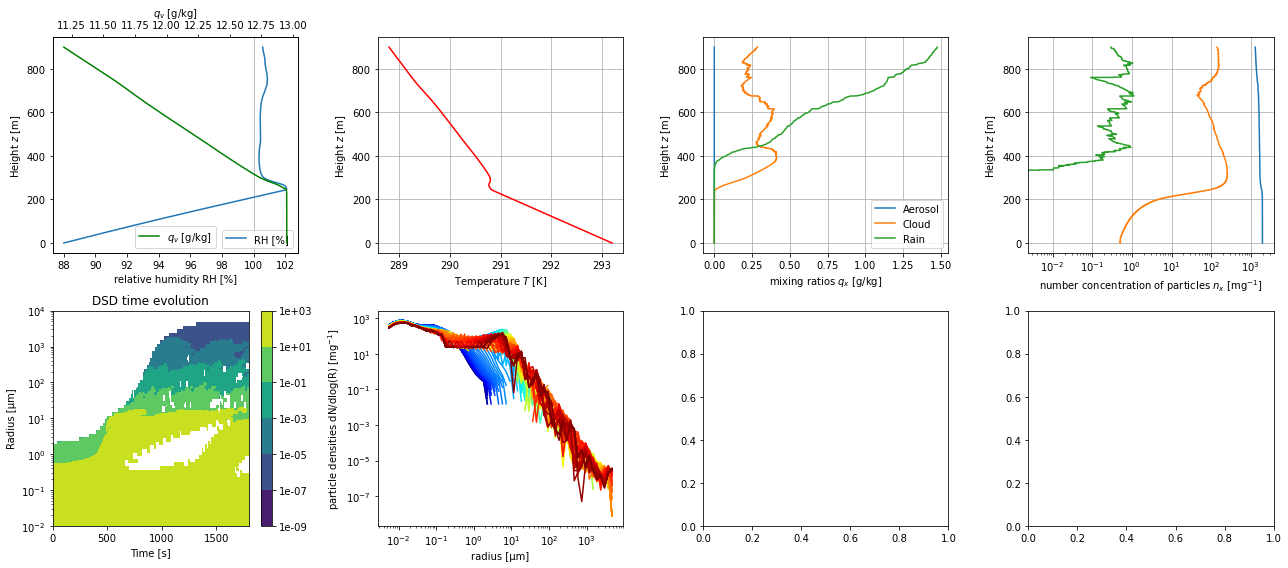

In [57]:
plot_mode=mode_plots_widget.value
subplot_array_function(plot_mode, dt, nt,rm_spec, qa_ts, qc_ts, qr_ts, na_ts, nc_ts, nr_ts, T_parcel_array, RH_parcel_array, q_parcel_array, z_parcel_array, spectra_arr)

## data output
options for saving output variables and drop size spectra

In [61]:
# save array of output variables into csv-file, optional filename can be given as filename='my_filename.csv'
save_model_output_variables(time_array, RH_parcel_array, q_parcel_array, T_parcel_array, z_parcel_array, qa_ts, \
                            qc_ts, qr_ts, na_ts, nc_ts, nr_ts, filename='testoutput_model_230809.csv')

Output data written to: output/testoutput_model_230809.csv


In [62]:
# save array of DSD spectra per timesteps, combined with radii to csv-file
save_model_output_dsd(spectra_arr, rm_spec, rl_spec, rr_spec, nt, filename='dsd_array_output_check_newlayout_230809.csv')

Output data of droplet size distribution written to: output/dsd_array_output_check_newlayout_230809.csv


## Test area for plot development
This could be a question / homework exercise

In [20]:
np.diff(T_parcel_array) / np.diff(z_parcel_array)

array([-0.00976122, -0.00976122, -0.00976122, ..., -0.00342517,
       -0.00343025, -0.00345568])

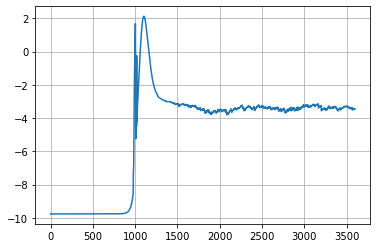

In [21]:
# test plot of the temperature gradient vs time K per km
plt.plot((np.diff(T_parcel_array) / np.diff(z_parcel_array))[1:nt+1]*1000)
plt.grid()